In [3]:
from google.colab import drive
drive.mount('/googledrive')

Mounted at /googledrive


In [27]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [28]:
# Function to load images and labels from a directory
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            image_path = os.path.join(folder, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (64, 64))  # Resize to 64x64
            images.append(img)
            labels.append(label)
    return images, labels

# Load dataset
def load_dataset(base_path):
    smile_folder = os.path.join(base_path, "smile")
    non_smile_folder = os.path.join(base_path, "non_smile")

    smile_images, smile_labels = load_images_from_folder(smile_folder, 1)
    non_smile_images, non_smile_labels = load_images_from_folder(non_smile_folder, 0)

    X = np.array(smile_images + non_smile_images)
    y = np.array(smile_labels + non_smile_labels)

    X = X.reshape(-1, 64, 64, 1) / 255.0  # Normalize to [0, 1] and add channel dimension
    y = to_categorical(y, 2)  # One-hot encode labels

    return X, y

# Load training data
train_base_path = "/googledrive/MyDrive/GSSOC24/Smile/Dataset"
X, y = load_dataset(train_base_path)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_cnn_model()
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 128)        

In [37]:
# Create an image data generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the model
batch_size = 32
epochs = 10

model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
          steps_per_epoch=len(X_train) // batch_size,
          validation_data=(X_val, y_val),
          epochs=epochs)


Epoch 1/10
30/30 [==============================] - 10s 349ms/step - loss: 0.2810 - accuracy: 0.8817 - val_loss: 0.1169 - val_accuracy: 0.9588
Epoch 2/10
30/30 [==============================] - 7s 228ms/step - loss: 0.2273 - accuracy: 0.9147 - val_loss: 0.1021 - val_accuracy: 0.9588
Epoch 3/10
30/30 [==============================] - 6s 206ms/step - loss: 0.2358 - accuracy: 0.9009 - val_loss: 0.1039 - val_accuracy: 0.9671
Epoch 4/10
30/30 [==============================] - 8s 274ms/step - loss: 0.2745 - accuracy: 0.8913 - val_loss: 0.1488 - val_accuracy: 0.9342
Epoch 5/10
30/30 [==============================] - 6s 202ms/step - loss: 0.2557 - accuracy: 0.8998 - val_loss: 0.1091 - val_accuracy: 0.9712
Epoch 6/10
30/30 [==============================] - 7s 221ms/step - loss: 0.2355 - accuracy: 0.9062 - val_loss: 0.1222 - val_accuracy: 0.9424
Epoch 7/10
30/30 [==============================] - 8s 277ms/step - loss: 0.2469 - accuracy: 0.9009 - val_loss: 0.1031 - val_accuracy: 0.9671
Epoch

In [38]:
# Evaluate the neural network
loss, accuracy = model.evaluate(X_val, y_val)
print("Validation Accuracy:", accuracy)


8/8 [==============================] - 0s 46ms/step - loss: 0.0894 - accuracy: 0.9712
Validation Accuracy: 0.9711934328079224


10/10 [==============================] - 1s 79ms/step


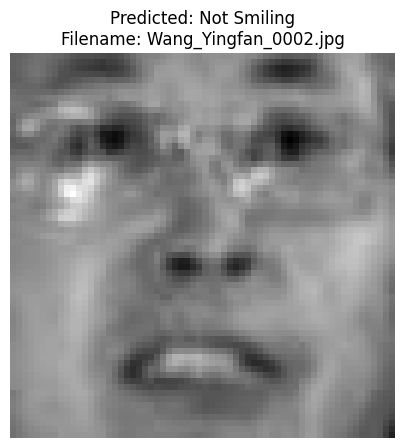

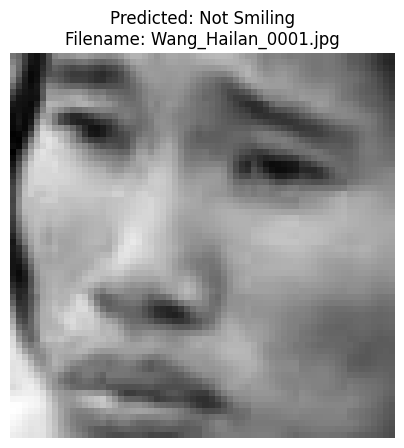

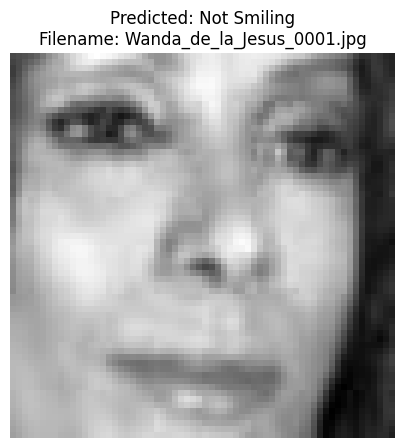

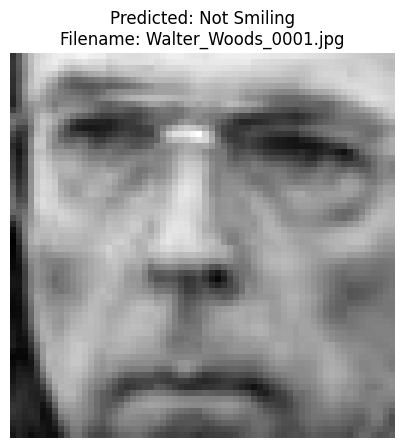

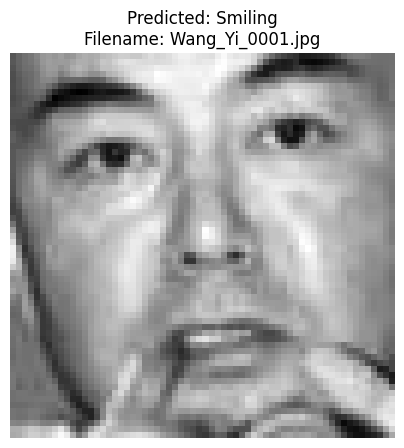

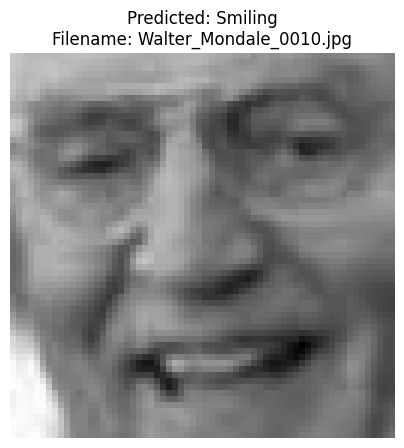

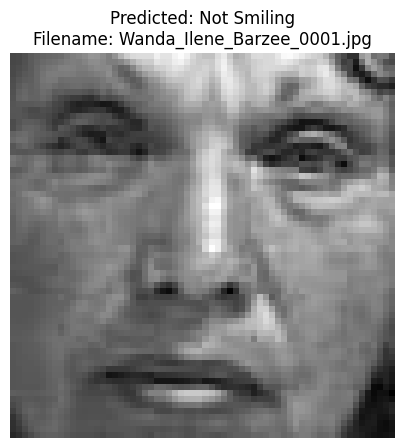

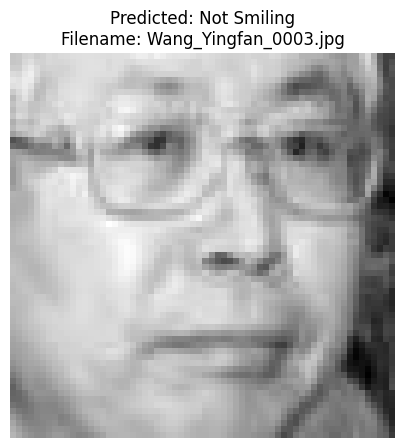

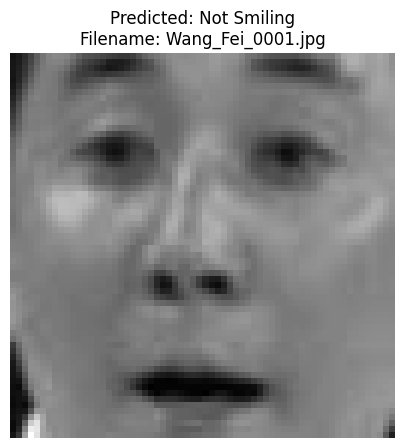

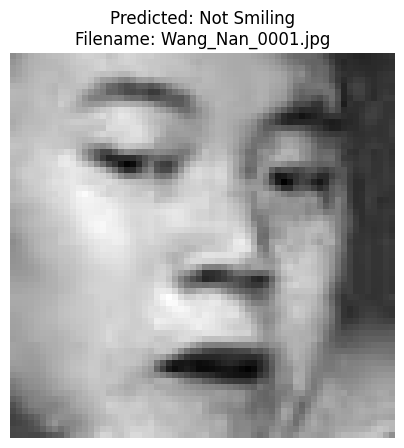

In [39]:
# Function to display images with predicted labels
def display_images_with_predictions(test_path, model, max_images=10):
    test_images = []
    test_filenames = []
    for filename in os.listdir(test_path):
        if filename.endswith(".jpg"):
            image_path = os.path.join(test_path, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (64, 64))
            test_images.append(img)
            test_filenames.append(filename)

    test_images = np.array(test_images).reshape(-1, 64, 64, 1) / 255.0
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)

    for i in range(min(len(test_images), max_images)):
        image = test_images[i].reshape(64, 64)
        predicted_label = "Smiling" if predicted_labels[i] == 1 else "Not Smiling"
        plt.figure(figsize=(5, 5))
        plt.imshow(image, cmap='gray')
        plt.title(f"Predicted: {predicted_label}\nFilename: {test_filenames[i]}")
        plt.axis('off')
        plt.show()

# Path to the test dataset
test_path = "/googledrive/MyDrive/GSSOC24/Smile/test"

# Display images with their predictions
display_images_with_predictions(test_path, model)


In [46]:
# Save the trained model
model_path = "/googledrive/MyDrive/GSSOC24/Smile/smiling_detection_model.h5"
model.save(model_path)
print("Model saved successfully at:", model_path)

# Function to load the saved model
def load_model(model_path):
    from tensorflow.keras.models import load_model
    return load_model(model_path)

# Load the model for future use
loaded_model = load_model(model_path)


Model saved successfully at: /googledrive/MyDrive/GSSOC24/Smile/smiling_detection_model.h5


Model loaded successfully from: /googledrive/MyDrive/GSSOC24/Smile/smiling_detection_model.h5
10/10 [==============================] - 1s 85ms/step


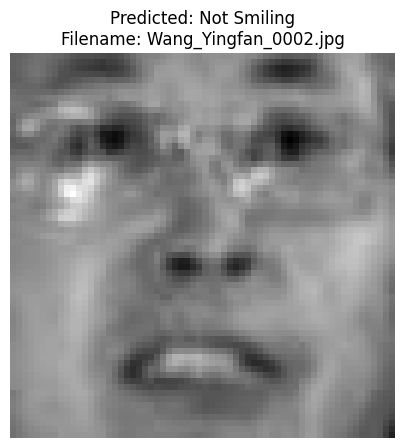

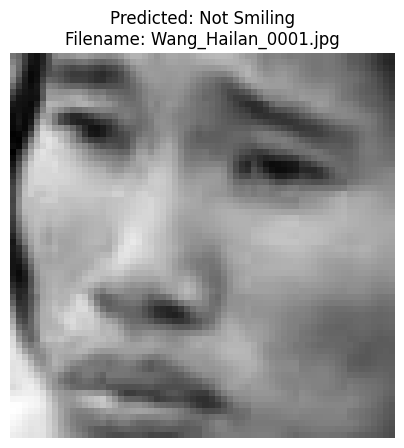

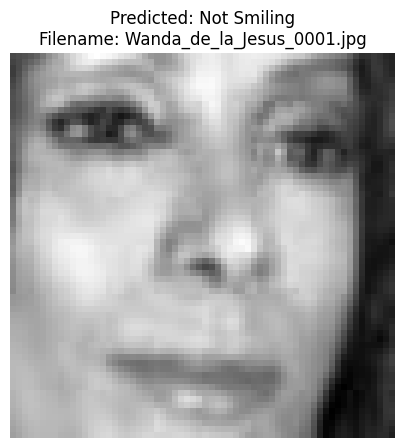

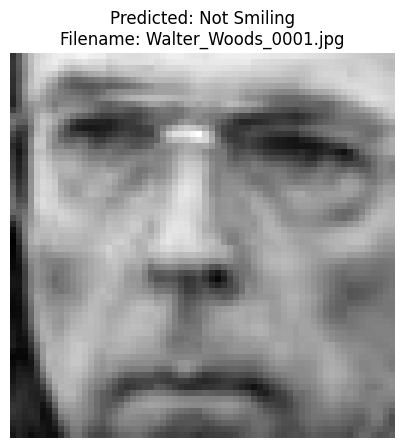

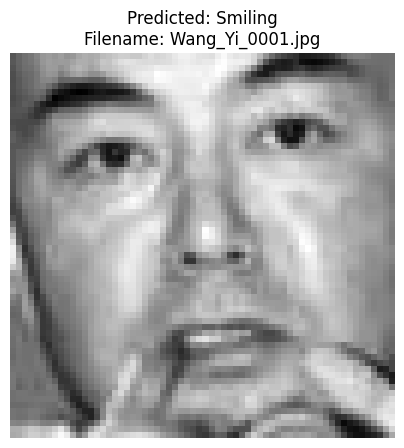

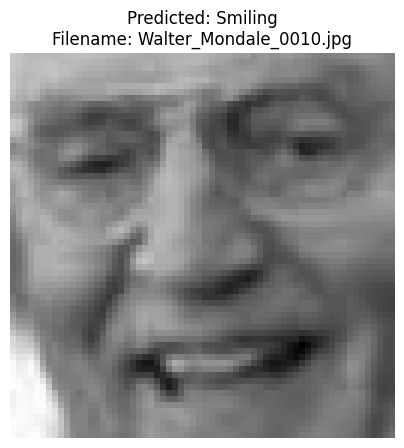

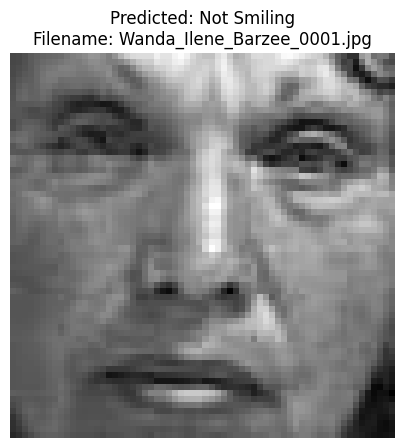

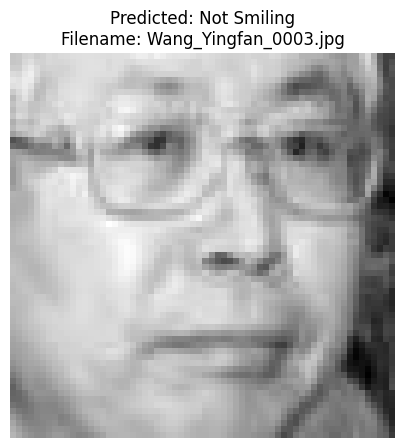

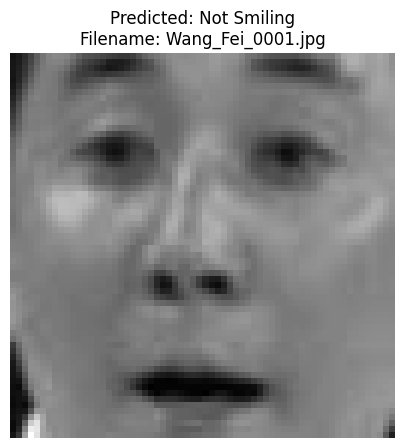

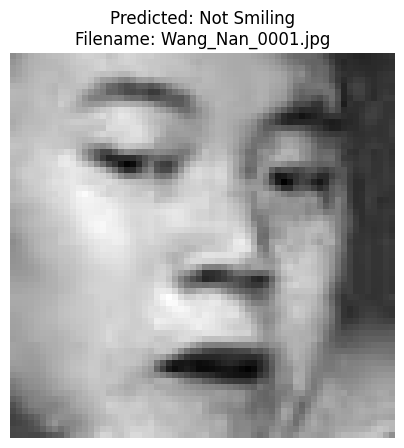

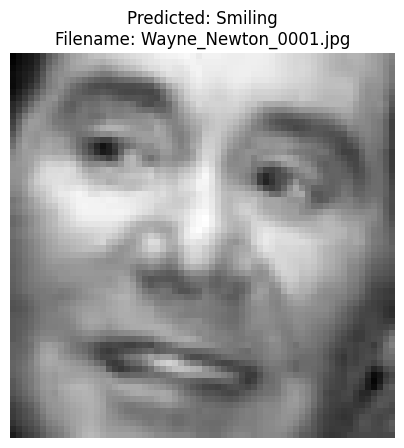

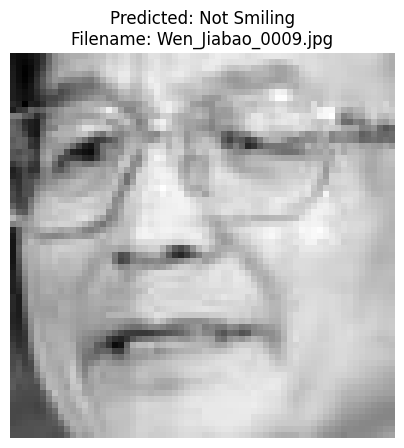

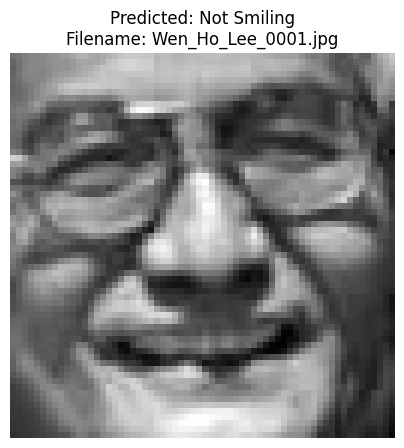

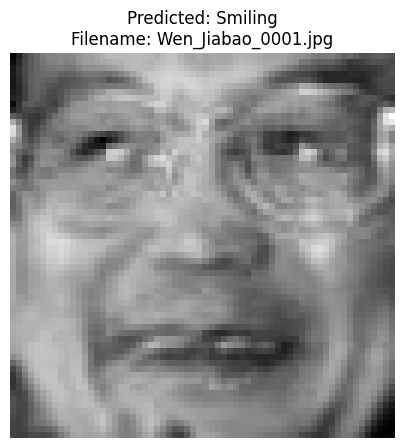

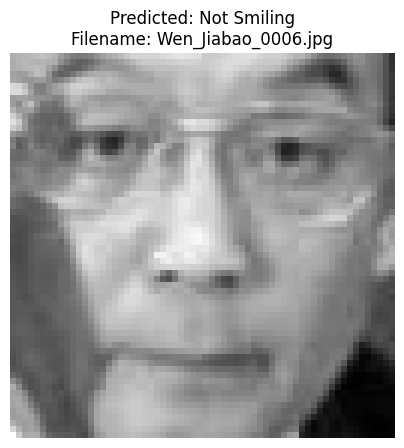

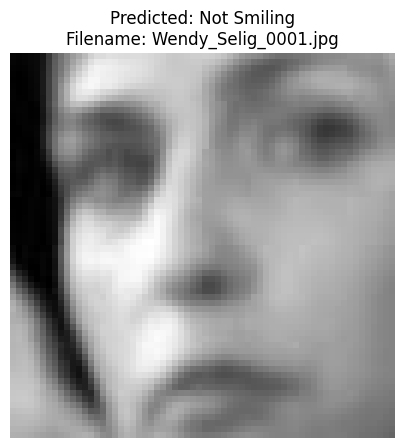

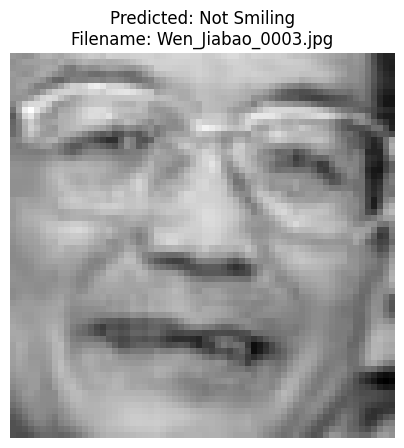

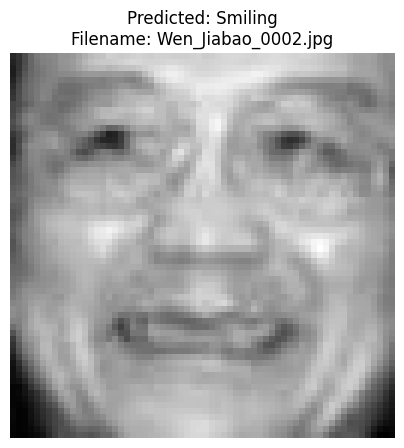

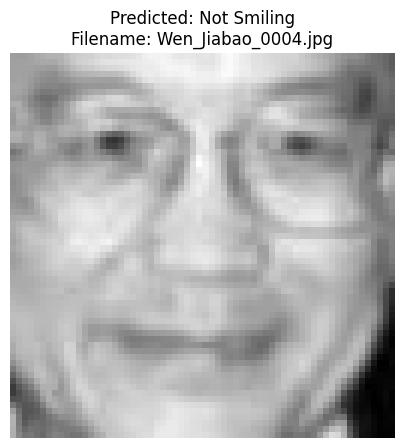

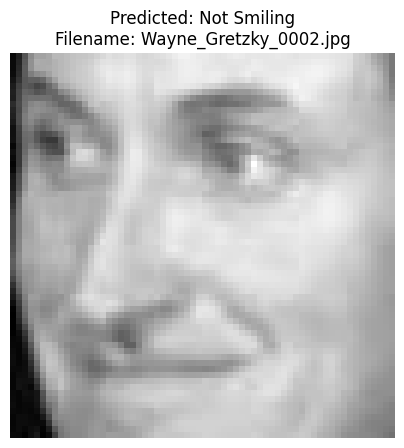

In [51]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Path to the saved model
model_path = "/googledrive/MyDrive/GSSOC24/Smile/smiling_detection_model.h5"

# Load the saved model
model = load_model(model_path)
print("Model loaded successfully from:", model_path)

# Function to load and preprocess test images from a folder
def load_test_images(test_folder):
    images = []
    filenames = []
    for filename in os.listdir(test_folder):
        if filename.endswith(".jpg"):
            image_path = os.path.join(test_folder, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (64, 64))  # Resize to match model input
            images.append(img)
            filenames.append(filename)
    return np.array(images), filenames

# Path to the test dataset
test_folder = "/googledrive/MyDrive/GSSOC24/Smile/test"

# Load test images
test_images, test_filenames = load_test_images(test_folder)
test_images = test_images.reshape(-1, 64, 64, 1) / 255.0  # Normalize and add channel dimension

# Function to display images with predicted labels
def display_images_with_predictions(images, filenames, model, max_images=20):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    for i in range(min(len(images), max_images)):
        image = images[i].reshape(64, 64)
        predicted_label = "Smiling" if predicted_labels[i] == 1 else "Not Smiling"
        plt.figure(figsize=(5, 5))
        plt.imshow(image, cmap='gray')
        plt.title(f"Predicted: {predicted_label}\nFilename: {filenames[i]}")
        plt.axis('off')
        plt.show()

# Display images with their predictions
display_images_with_predictions(test_images, test_filenames, model, max_images=20)
